# Setup

In [3]:
# from nilearn import datasets
from nilearn import plotting # 3D visualization 
from nilearn import image
from nilearn.connectome import ConnectivityMeasure
from nilearn.maskers import NiftiMapsMasker

import numpy as np
import pandas as pd
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from pygsp import graphs, filters

sns.set_theme()


c:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\.venv\lib\site-packages\nilearn\__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


# Data diagnosis

In [6]:
data_folder = Path().resolve().parent / '__data'
run = '01'
print(f"Data folder : {data_folder}")

Data folder : C:\Users\INES\Documents\3A_MVA\ML_for_TS\TimeSeries-GraphSignalProcessing\__data


In [38]:
ROIs_maps_filename = data_folder / f'subCSI1_ROIs_maps.nii.gz' # depend of the run ?

if not ROIs_maps_filename.exists():
    brainmask_files = sorted(glob.glob(str(data_folder / 'sub1ROIs' / 'subCSI1')+'*_brainmask*'))  # depend of the run ?
    sum_img = image.load_img(brainmask_files[0])
    atlas_files = sorted(glob.glob(str(data_folder / 'sub1ROIs' / 'subCSI1')+'*_mask*')) # to sort ?
    print(f"There are {len(atlas_files)} ROIs")
    maps = image.concat_imgs(atlas_files)



    print(f"Size of images : {maps.shape}")
    print(f"Labels values: {np.unique(maps.get_fdata())}")
    maps.to_filename(str(ROIs_maps_filename))

In [2]:
# ROIs_mask_filename.unlink()

In Nilearn, **confounds** are subsets of variables that are used to model and remove unwanted sources of variability from fMRI data1. They are typically used to remove noise sources such as head motion, physiological noise, and scanner artifacts from the fMRI signal

In [40]:
img_files = glob.glob(str(data_folder / 'subCSI1') + '*preproc*')
confounds_filename = data_folder / 'sub1_ses01_run01_confounds.tsv'
confounds_df = pd.read_csv(confounds_filename, sep='\t')
print(confounds_df.columns)
confounds_df.bfill(inplace=True)
print(confounds_df.shape)

Index(['CSF', 'WhiteMatter', 'GlobalSignal', 'stdDVARS', 'non-stdDVARS',
       'vx-wisestdDVARS', 'FramewiseDisplacement', 'tCompCor00', 'tCompCor01',
       'tCompCor02', 'tCompCor03', 'tCompCor04', 'tCompCor05', 'aCompCor00',
       'aCompCor01', 'aCompCor02', 'aCompCor03', 'aCompCor04', 'aCompCor05',
       'Cosine00', 'Cosine01', 'Cosine02', 'Cosine03', 'Cosine04',
       'NonSteadyStateOutlier00', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ'],
      dtype='object')
(194, 31)


In [41]:
img_filename = img_files[0]
im = image.load_img(img_filename)
print(im.shape)

(71, 89, 72, 194)


In [42]:
masker = NiftiMapsMasker(maps_img=ROIs_maps_filename,
                         standardize='zscore_sample',
                         standardize_confounds='zscore_sample',
                         )
time_series = masker.fit_transform(img_filename, confounds=confounds_df)
print(time_series.shape)

(194, 10)


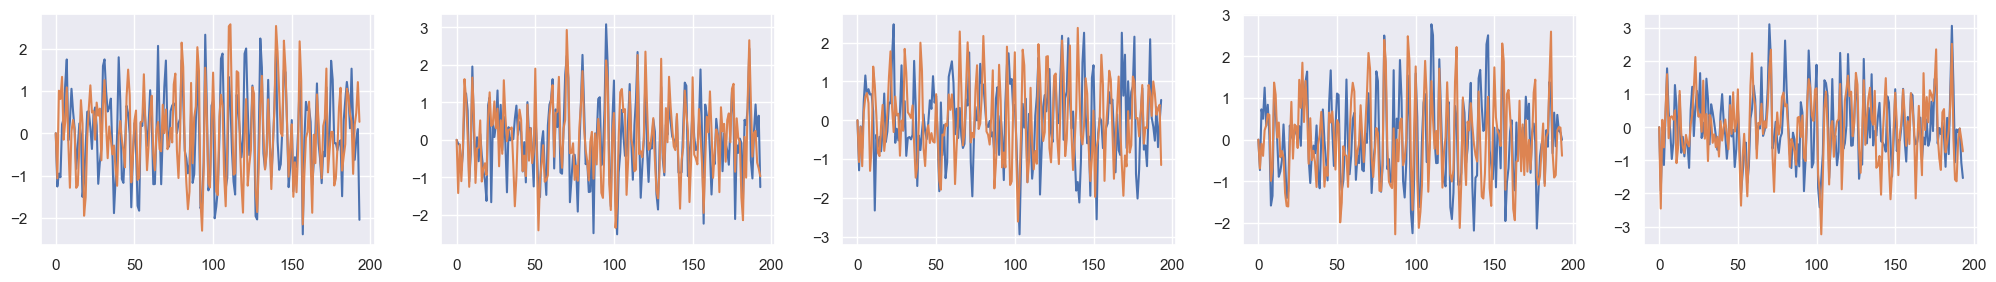

In [51]:

fig, ax = plt.subplots(1, 5, figsize=(25, 3))
for i in range(5):
    ax[i].plot(time_series[:, 2*i:2*(i+1)])

plt.show()

(10, 10)


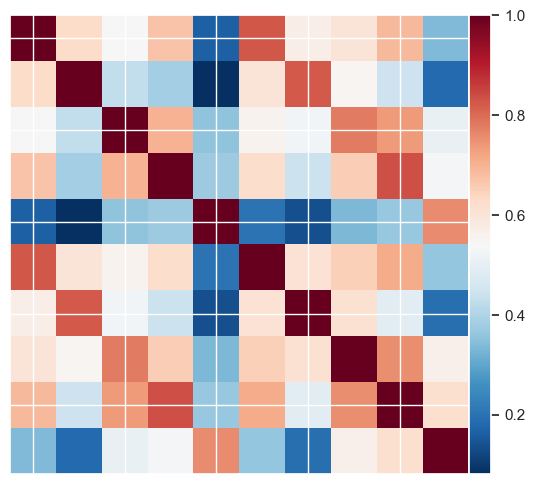

In [54]:
correlation_measure = ConnectivityMeasure(
    kind="correlation",
    standardize="zscore_sample",
)
correlation_matrix = correlation_measure.fit_transform([time_series])[0]
print(correlation_matrix.shape)
plotting.plot_matrix(correlation_matrix)
plt.show()

In [58]:

coordinates = plotting.find_probabilistic_atlas_cut_coords(ROIs_maps_filename)
print(coordinates.shape)

(10, 3)


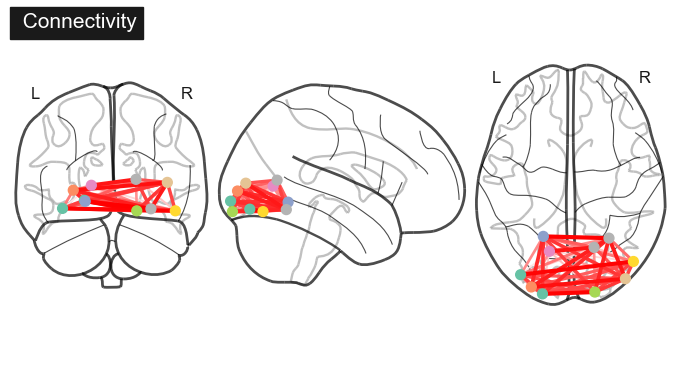

In [64]:
plotting.plot_connectome(correlation_matrix,
                         coordinates,
                        #  edge_threshold="100%",
                         title=' Connectivity')
plt.show()

In [65]:
view = plotting.view_connectome(
    correlation_matrix, coordinates,
)
view

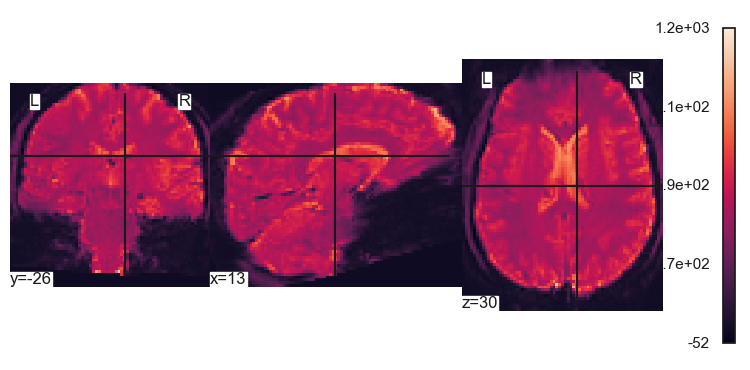

In [67]:

# plot 3D image
# plot_stat_map : plot cuts of an ROI/mask image at optional cut_coords (a tuple of floats or int)
#plotting.plot_stat_map(first_img, bg_img=None)
first_img = image.index_img(img_filename, 0)
# plotting.plot_img : plot cuts of a given image at optional cut_coords (MNI coordinates of the point where the cut is performed), return an output_file
plotting.plot_img(first_img, 
                  colorbar=True) # Warning : the img is not computed in the MNI space ?
plt.show()  

In [69]:
G = graphs.Graph(correlation_matrix)
G.compute_fourier_basis() # recompute=True
print(f'Graph eigenvalues : {G.e.shape}')
print(f'Graph eigenvectors : {G.U.shape}')

2023-12-12 16:06:35,460:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


Graph eigenvalues : (10,)
Graph eigenvectors : (10, 10)


# Compute brain graph 
 Construct connectivity matrix and graph (node feature + adjacency matrix )

Register the data to an atlas that enables extration of time series ??

In [68]:
percentile = 80
threshold = np.percentile(np.abs(correlation_matrix), percentile)
print(f'threshold : {threshold}')
result_matrix = np.where(np.abs(correlation_matrix) > threshold, correlation_matrix, 0)
print(f"result shape : {result_matrix.shape}")

threshold : 0.7556841337361404
result shape : (10, 10)


In [16]:
A = (result_matrix != 0).astype(int)
np.fill_diagonal(A, 0)
print(f"A shape : {A.shape}")

G = graphs.Graph(A)

A shape : (39, 39)


In [95]:
nb_regions = G.N

G.compute_fourier_basis() # recompute=True
print(f'Graph eigenvalues : {G.e.shape}')
print(f'Graph eigenvectors : {G.U.shape}')

Graph eigenvalues : (39,)
Graph eigenvectors : (39, 39)


In [97]:
from functools import partial

# select n lowest frequencies
n = 10
sorted_eigenvalues = np.sort(G.e)
low_threshold_eigenvalue = sorted_eigenvalues[n]
high_threshold_eigenvalue = sorted_eigenvalues[-n]

print(f'low threshold eigenvalue : {low_threshold_eigenvalue}')
print(f'high threshold eigenvalue : {high_threshold_eigenvalue}')

def low_pass_g(x, threshold=0.1):
    return (x <= threshold) * 1

def high_pass_g(x, threshold=0.1):
    return (x >= threshold) * 1

def g(x, tau=1):
    return 1. / (1. + tau * x)
g = filters.Filter(G, g)
al_g = partial(low_pass_g, threshold=low_threshold_eigenvalue)
li_g = partial(high_pass_g, threshold=high_threshold_eigenvalue)


low threshold eigenvalue : 0.9062869564634821
high threshold eigenvalue : 16.42275184726981


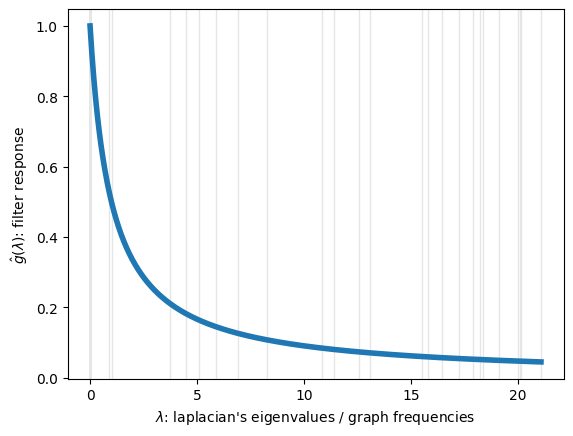

In [98]:
fig, ax = plt.subplots()
g.plot(plot_eigenvalues=True, ax=ax)

In [99]:
al_g = filters.Filter(G, al_g)
li_g = filters.Filter(G, li_g)

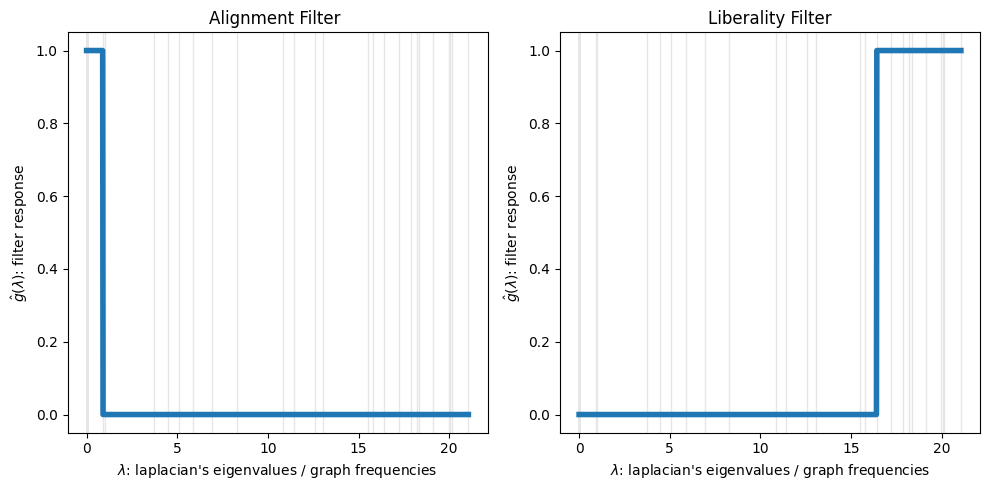

In [100]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
al_g.plot(plot_eigenvalues=True, ax=ax[0])
_ = ax[0].set_title('Alignment Filter ')

li_g.plot(plot_eigenvalues=True, ax=ax[1])
_ = ax[1].set_title('Liberality Filter')

fig.tight_layout()


# Filtering 

In the studied article, they perform graph signal filtering with two different filtering matrices 

$\psi_{Al}$ : low pass filtering for alignment; so that $Y_{\phi_{Al}} = V\psi_{Al}V^TX$ is the transformed functional data in which only the then lowest frequency modes are expressed 

$\psi_{Li}$ : high-pass filtering; for liberality, only the ten highest frequency modes 
to derive a subject-specific alignment and liberality concentration, they compute the norms of the filtered signal, averaged across all temporal samples of a given subject.

In [101]:
al_filtered_signal = al_g.filter(signal)
li_filtered_signal = li_g.filter(signal)
print(f'low pass filtered signal shape : {al_filtered_signal.shape}')
print(f'high pass filtered signal shape : {li_filtered_signal.shape}')

low pass filtered signal shape : (39, 194)
high pass filtered signal shape : (39, 194)


In [102]:
coords = np.array(coords)
print(coords[:, :2].shape)
G.set_coordinates(coords)

(39, 2)


In [58]:
signal[:, 0].shape

(39,)

In [105]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# G.plot_signal(signal[:, 0], vertex_size=30, ax=ax)
# ax.set_axis_off()

In [1]:
plotting.plot_markers(signal[:, 2], coords, title='Original signal')
plotting.show()

NameError: name 'plotting' is not defined

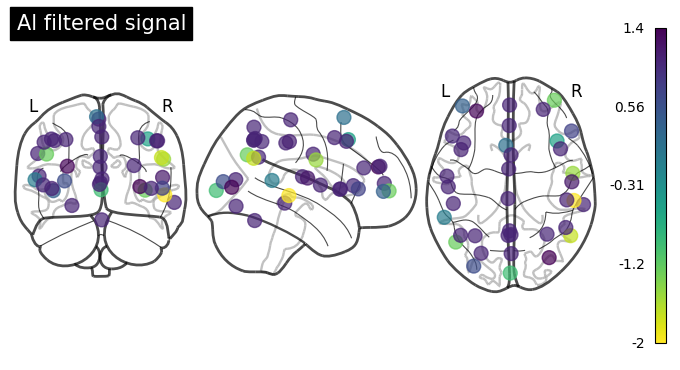

In [108]:
plotting.plot_markers(al_filtered_signal[:, 2], coords, title='Al filtered signal')
plotting.show()

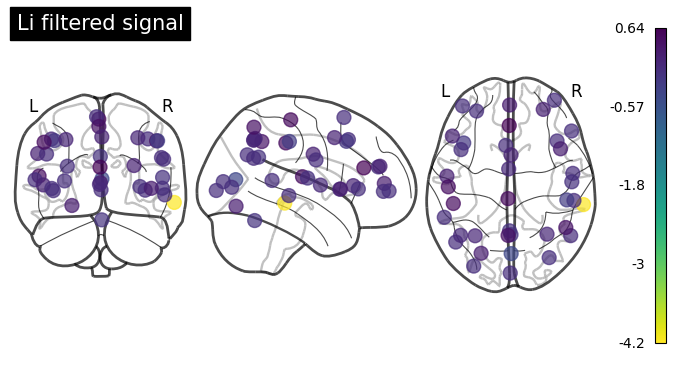

In [107]:
plotting.plot_markers(li_filtered_signal[:, 2], coords, title='Li filtered signal')
plotting.show()

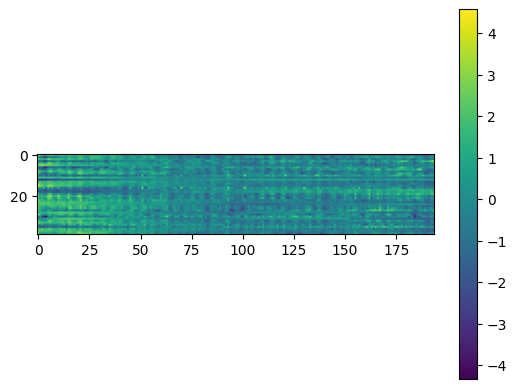

In [88]:
plt.imshow(signal)
plt.colorbar()

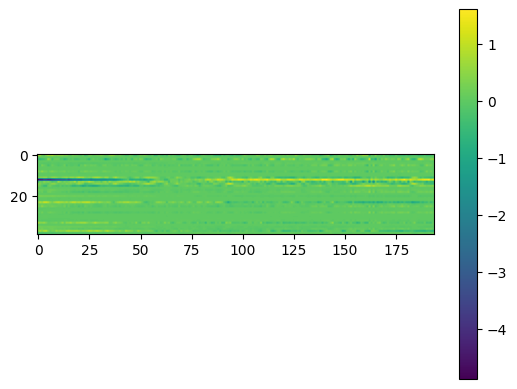

In [89]:
plt.imshow(li_filtered_signal)
plt.colorbar()